## Importing SGMA Wells Data

In [1]:
import os
import ee
import geemap
import json

import pandas as pd
import numpy as np
import scipy
import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import geometry
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)


In [2]:

SGMA_GWE = pd.read_csv('SGMA_Elevation_16_17/GroundwaterElevation.csv')

#MSMT_DATE - Water Level Measurement Date (PST) 
#WSE – Water Surface Elevation (feet, above mean sea level)
#RPE_WSE - Reference Point Elevation to Water Surface Elevation
#GSE_WSE - Ground Surface Elevation to Water Surface Elevation
#WLM_RPE - RPE for specific water level measurement (WLM)
#WLM_GSE - GSE for specific water level measurement (WLM)
#RDNG_RP - Reading at Reference Point
#RDNG_WS - Reading at Water Surface

#WSE + RPE_WSE == WLM_RPE
#WSE + GSE_WSE == WLM_GSE
#RDNG_RP == RPE_WSE

print(SGMA_GWE.shape)
SGMA_GWE.head()

(957461, 22)


,SITE_CODE,WELL_NAME,SWN,STN_ID,MSMT_DATE,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,RDNG_RP,RDNG_WS,WLM_ORG_ID,WLM_ORG_NAME,WLM_DESC,WLM_ACC_CODE,WLM_ACC_DESC,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER
0,338552N1178566W001,AMD-1/MP10,NaN,47291,1995-10-27 11:00:00.0,116.788,101.91,103.34,218.698,220.128,101.91,0.0,5045,Orange County Water District,Electronic pressure transducer,0.01 Ft,Water level accuracy to nearest hundredth of a...,NaN,NaN,NaN,2017-11-03 18:02:03.0,rherndon@ocwd.com
1,338552N1178566W001,AMD-1/MP10,NaN,47291,2000-05-15 11:04:00.0,125.218,93.48,94.91,218.698,220.128,93.48,0.0,5045,Orange County Water District,Electronic pressure transducer,0.01 Ft,Water level accuracy to nearest hundredth of a...,NaN,NaN,NaN,2017-11-03 18:02:03.0,rherndon@ocwd.com
2,338552N1178566W003,AMD-1/MP5,NaN,47293,1990-09-12 11:07:00.0,75.398,143.30,144.73,218.698,220.128,143.30,0.0,5045,Orange County Water District,Electronic pressure transducer,0.01 Ft,Water level accuracy to nearest hundredth of a...,NaN,NaN,NaN,2017-11-03 18:02:03.0,rherndon@ocwd.com
3,338552N1178566W001,AMD-1/MP10,NaN,47291,2007-08-02 11:13:00.0,111.828,106.87,108.30,218.698,220.128,106.87,0.0,5045,Orange County Water District,Electronic pressure transducer,0.01 Ft,Water level accuracy to nearest hundredth of a...,NaN,NaN,NaN,2017-11-03 18:02:03.0,rherndon@ocwd.com
4,338649N1178024W001,AM-3,03S09W34J006S,47274,1996-05-10 11:20:00.0,247.387,28.20,28.91,275.587,276.297,28.20,0.0,5045,Orange County Water District,Electric sounder measurement,0.01 Ft,Water level accuracy to nearest hundredth of a...,NaN,NaN,NaN,2017-11-03 18:02:03.0,rherndon@ocwd.com


In [3]:
#SGMA_GWE['ordinal'] = [pd.Timestamp.toordinal(x) for x in pd.to_datetime(SGMA_GWE.MSMT_DATE)]

# plot non-parametric kde on numeric datenum
#ax = SGMA_GWE['ordinal'].plot(kind='kde')
# rename the xticks with labels
#x_ticks = ax.get_xticks()
#ax.set_xticks(x_ticks[::2])
#xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
#ax.set_xticklabels(xlabels)

In [4]:
start_date = '01-01-2015'
SGMA_GWE.MSMT_DATE = pd.to_datetime(SGMA_GWE.MSMT_DATE)
SGMA_GWE_masked = SGMA_GWE.loc[SGMA_GWE['MSMT_DATE'] > start_date]
SGMA_GWE_masked.shape

(273287, 22)

In [5]:
#SGMA_GWE_masked['ordinal'] = [pd.Timestamp.toordinal(x) for x in pd.to_datetime(SGMA_GWE_masked.MSMT_DATE)]

# plot non-parametric kde on numeric datenum
#ax = SGMA_GWE_masked['ordinal'].plot(kind='kde')
# rename the xticks with labels
#x_ticks = ax.get_xticks()
#ax.set_xticks(x_ticks[::2])
#xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
#ax.set_xticklabels(xlabels)

In [6]:
SGMA_Station = pd.read_csv('SGMA_Elevation_16_17/Station.csv')

# WELL_DEPTH - Well Depth (feet bgs) 
# TOP_PRF - Top Perforation (feet bgs)       
# BOT_PRF -  Bottom Perforation (feet bgs)       
# GSE  -  Ground Surface Elevation    
# RPE  - Reference Point Elevation         
# RP_DESC  - Reference Point Description  

print(SGMA_Station.shape)
SGMA_Station.head()

(9768, 28)


,SITE_CODE,WELL_NAME,SWN,STN_ID,WCR_NO,LATITUDE,LONGITUDE,STN_ORG_ID,STN_ORG_NAME,LOC_DESC,WELL_USE,WELL_TYPE,WELL_DEPTH,TOP_PRF,BOT_PRF,GSE,RPE,RP_DESC,STN_CMT,STN_MOD_DATE,STN_MOD_USER,WLM_METHOD,WLM_ACC,COUNTY,HR,BASIN_CODE,BASIN_NAME,BASIN_RO
0,347966N1165191W001,08N04E11K01,08N04E11K001S,38596,NaN,34.796650,-116.519932,5161.0,Mojave Water Agency,NaN,Unknown,Single Well,NaN,NaN,NaN,1809.897,1809.897,Unknown,NaN,2019-04-11 18:03:58.0,CLUDLUM_DBA,Digital Elevation Model,10 ft.,San Bernardino,South Lahontan,6-040,Lower Mojave River Valley,80238.0
1,355197N1192470W001,4D22I7,28S25E02K001M,39443,NaN,35.519700,-119.247000,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN,377.490,378.490,None Provided,NaN,2017-11-03 18:02:50.0,DA LOAD,Unknown,Unknown,Kern,Tulare Lake,5-022.14,Kern County,80237.0
2,352027N1188996W001,RMW-041,31S29E30J001M,37594,NaN,35.199567,-118.898542,NaN,NaN,NaN,Irrigation,Single Well,NaN,NaN,NaN,376.000,376.000,ground surface,NaN,2020-01-25 11:05:32.0,bgooding,Digital Elevation Model,10 ft.,Kern,Tulare Lake,5-022.14,Kern County,80237.0
3,352969N1191471W001,6E261,30S26E26A001M,37631,NaN,35.296900,-119.147100,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN,344.920,345.720,None Provided,NaN,2017-11-03 18:02:50.0,DA LOAD,Unknown,Unknown,Kern,Tulare Lake,5-022.14,Kern County,80237.0
4,359125N1194293W001,NaN,23S23E24J001M,37648,NaN,35.912500,-119.429300,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN,205.700,205.700,None Provided,NaN,2017-11-03 18:02:50.0,DA LOAD,Unknown,Unknown,Tulare,Tulare Lake,5-022.13,Tule,80237.0


In [7]:
SGMA_Merged = pd.merge(SGMA_GWE_masked,SGMA_Station, how= 'left', on='STN_ID', suffixes = ('_GWE','_Station'))
print(SGMA_Merged.shape)
SGMA_Merged.head()

(273287, 49)


,SITE_CODE_GWE,WELL_NAME_GWE,SWN_GWE,STN_ID,MSMT_DATE,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,RDNG_RP,RDNG_WS,WLM_ORG_ID,WLM_ORG_NAME,WLM_DESC,WLM_ACC_CODE,WLM_ACC_DESC,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER,SITE_CODE_Station,WELL_NAME_Station,SWN_Station,WCR_NO,LATITUDE,LONGITUDE,STN_ORG_ID,STN_ORG_NAME,LOC_DESC,WELL_USE,WELL_TYPE,WELL_DEPTH,TOP_PRF,BOT_PRF,GSE,RPE,RP_DESC,STN_CMT,STN_MOD_DATE,STN_MOD_USER,WLM_METHOD,WLM_ACC,COUNTY,HR,BASIN_CODE,BASIN_NAME,BASIN_RO
0,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 11:00:00,19.39,164.15,164.55,183.54,183.94,164.15,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:41.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0
1,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 13:00:00,19.70,163.84,164.24,183.54,183.94,163.84,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:43.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0
2,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 14:00:00,19.82,163.72,164.12,183.54,183.94,163.72,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:45.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0
3,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 21:00:00,18.17,165.37,165.77,183.54,183.94,165.37,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:47.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0
4,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 05:00:00,18.68,164.86,165.26,183.54,183.94,164.86,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:49.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0


In [8]:
SGMA_Merged['SUB_SL'] = SGMA_Merged['WELL_DEPTH'] - SGMA_Merged['WLM_GSE']
SGMA_Merged['NET_WL'] = SGMA_Merged['SUB_SL'] + SGMA_Merged['WSE']

SGMA_Merged.head()

,SITE_CODE_GWE,WELL_NAME_GWE,SWN_GWE,STN_ID,MSMT_DATE,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,RDNG_RP,RDNG_WS,WLM_ORG_ID,WLM_ORG_NAME,WLM_DESC,WLM_ACC_CODE,WLM_ACC_DESC,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER,SITE_CODE_Station,WELL_NAME_Station,SWN_Station,WCR_NO,LATITUDE,LONGITUDE,STN_ORG_ID,STN_ORG_NAME,LOC_DESC,WELL_USE,WELL_TYPE,WELL_DEPTH,TOP_PRF,BOT_PRF,GSE,RPE,RP_DESC,STN_CMT,STN_MOD_DATE,STN_MOD_USER,WLM_METHOD,WLM_ACC,COUNTY,HR,BASIN_CODE,BASIN_NAME,BASIN_RO,SUB_SL,NET_WL
0,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 11:00:00,19.39,164.15,164.55,183.54,183.94,164.15,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:41.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.45
1,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 13:00:00,19.70,163.84,164.24,183.54,183.94,163.84,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:43.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.76
2,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 14:00:00,19.82,163.72,164.12,183.54,183.94,163.72,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:45.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.88
3,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 21:00:00,18.17,165.37,165.77,183.54,183.94,165.37,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:47.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,254.23
4,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 05:00:00,18.68,164.86,165.26,183.54,183.94,164.86,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:49.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,254.74


http://geologyandpython.com/ml-interpolation-method.html

In [9]:
SGMA_Merged['geometry'] = [geometry.Point(x, y) for x, y in zip(SGMA_Merged['LONGITUDE'], SGMA_Merged['LATITUDE'])]
SGMA_Merged_gpd = gpd.GeoDataFrame(SGMA_Merged, geometry='geometry', crs="epsg:4326")

SGMA_Merged_gpd.head()

,SITE_CODE_GWE,WELL_NAME_GWE,SWN_GWE,STN_ID,MSMT_DATE,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,RDNG_RP,RDNG_WS,WLM_ORG_ID,WLM_ORG_NAME,WLM_DESC,WLM_ACC_CODE,WLM_ACC_DESC,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER,SITE_CODE_Station,WELL_NAME_Station,SWN_Station,WCR_NO,LATITUDE,LONGITUDE,STN_ORG_ID,STN_ORG_NAME,LOC_DESC,WELL_USE,WELL_TYPE,WELL_DEPTH,TOP_PRF,BOT_PRF,GSE,RPE,RP_DESC,STN_CMT,STN_MOD_DATE,STN_MOD_USER,WLM_METHOD,WLM_ACC,COUNTY,HR,BASIN_CODE,BASIN_NAME,BASIN_RO,SUB_SL,NET_WL,geometry
0,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 11:00:00,19.39,164.15,164.55,183.54,183.94,164.15,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:41.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.45,POINT (-121.97582 36.99663)
1,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 13:00:00,19.70,163.84,164.24,183.54,183.94,163.84,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:43.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.76,POINT (-121.97582 36.99663)
2,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-25 14:00:00,19.82,163.72,164.12,183.54,183.94,163.72,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:45.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,255.88,POINT (-121.97582 36.99663)
3,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 21:00:00,18.17,165.37,165.77,183.54,183.94,165.37,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:47.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-County,80237.0,236.06,254.23,POINT (-121.97582 36.99663)
4,369966N1219758W002,Thurber Lane Deep,NaN,46869,2018-12-26 05:00:00,18.68,164.86,165.26,183.54,183.94,164.86,0.0,6544,Santa Cruz Mid-County Groundwater Agency GSA,Electronic pressure transducer,0.1 Ft,Water level accuracy to nearest tenth of a foot,NaN,NaN,NaN,2020-04-09 09:49:49.0,bgooding,369966N1219758W002,Thurber Lane Deep,NaN,e019118,36.99663,-121.97582,5057.0,Santa Cruz County Environmental Health Services,4675 Thurber Lane,Observation,Part of a nested/multi-completion well,420.0,380.0,420.0,183.94,183.54,"Top of 2"" PVC casing",NaN,2020-01-17 16:52:33.0,bgooding,Digital aerial photo,0.1 ft.,Santa Cruz,Central Coast,3-001,Santa Cruz Mid-Co

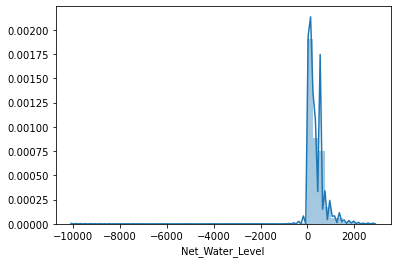

In [10]:
NET_WL = SGMA_Merged_gpd['NET_WL']

ax = sns.distplot(NET_WL, axlabel='Net_Water_Level')

In [11]:
NET_WL.loc[NET_WL < NET_WL.quantile(.001)] = np.nan
NET_WL.loc[NET_WL > NET_WL.quantile(.98)] = np.nan

vmin = 0
vmax = 1500

/home/aaron/anaconda3/envs/farmview_maps/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
cmap = 'Spectral_r'
    
plt.style.use('seaborn-notebook')


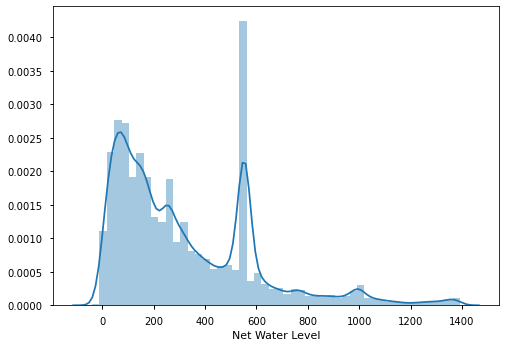

In [13]:
ax = sns.distplot(SGMA_Merged_gpd.NET_WL.dropna(), axlabel='Net Water Level')

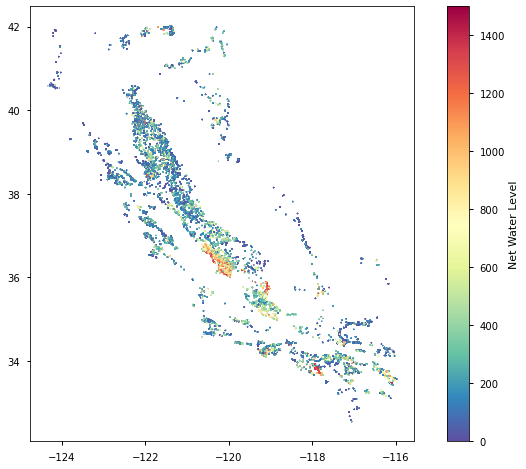

In [14]:
plt.scatter(SGMA_Merged_gpd.LONGITUDE, SGMA_Merged_gpd.LATITUDE, cmap=cmap, s=1, c=NET_WL, vmin=vmin, vmax=vmax)
plt.colorbar(label=u'Net Water Level')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(12, 8)

In [15]:
import fiona
import rasterio.mask
import descartes

shape_dest = '/home/aaron/Desktop/climate_maps/ca-state-boundary/CA_State_TIGER2016.shp'

In [16]:
shape_file = gpd.read_file(shape_dest)
shape_file = shape_file.to_crs('EPSG:4326')
shape_file.to_file('CA_bound_reproj.shp')

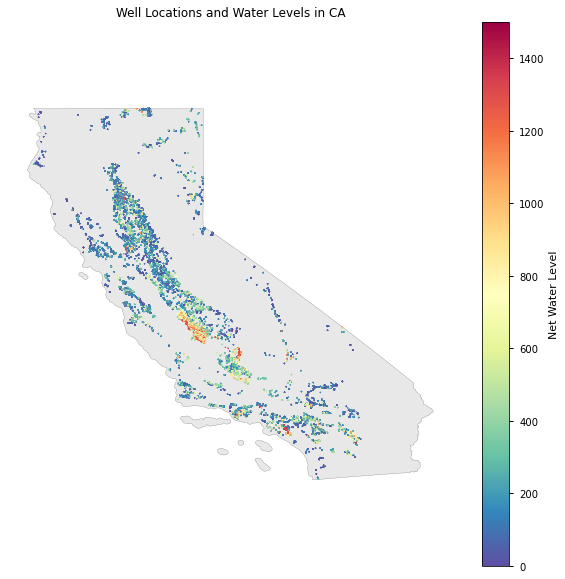

In [17]:
fig, ax = plt.subplots(figsize = (10, 10))

# first setup the plot using the crop_extent layer as the base layer 
shape_file.plot(color='lightgrey',
                      edgecolor = 'black',
                      ax = ax,
                      alpha=.5)


#ax.scatter(SGMA_Merged_gpd.LONGITUDE, SGMA_Merged_gpd.LATITUDE, 
#           cmap=cmap, s=40, c=NET_WL, vmin=vmin, vmax=vmax, linewidths=1, edgecolors='k')

plt.scatter(SGMA_Merged_gpd.LONGITUDE, SGMA_Merged_gpd.LATITUDE, cmap=cmap, s=1, c=NET_WL, vmin=vmin, vmax=vmax)
plt.colorbar(label=u'Net Water Level')

# add a title to the plot
ax.set_title('Well Locations and Water Levels in CA')
ax.set_axis_off()

plt.axis('equal')
plt.show()



In [18]:
pixel_size = 0.02
x_range = np.arange(SGMA_Merged_gpd.LONGITUDE.min() - SGMA_Merged_gpd.LONGITUDE.min() % pixel_size,
                    SGMA_Merged_gpd.LONGITUDE.max(), pixel_size)
y_range = np.arange(SGMA_Merged_gpd.LATITUDE.min() - SGMA_Merged_gpd.LATITUDE.min() % pixel_size,
                    SGMA_Merged_gpd.LATITUDE.max(), pixel_size)[::-1]

In [19]:
# CA Shapefile Extents
X_Min = shape_file.iloc[0].geometry.bounds[0] # Min Long (leftmost)
Y_Min = shape_file.iloc[0].geometry.bounds[1] # Min Lat (bottom)
X_Max = shape_file.iloc[0].geometry.bounds[2] # Max Long (rightmost)
Y_Max = shape_file.iloc[0].geometry.bounds[3] # Max Lat (top)
print(X_Min, X_Max, Y_Min, Y_Max)

-124.48201686078049 -114.13122247508855 32.52883673637251 42.00950826967187


In [20]:
# Set pixel size and range in x and y axes
pixel_size = 0.02
x_range = np.arange(X_Min - X_Min % pixel_size,
                    X_Max, pixel_size)
y_range = np.arange(Y_Min -  Y_Min % pixel_size,
                    Y_Max, pixel_size)[::-1]

In [21]:
# Set the shape and extent of the grid
shape = (len(y_range), len(x_range))
extent = xmin, xmax, ymin, ymax = x_range.min(), x_range.max(), y_range.min(), y_range.max()
x_mesh, y_mesh = np.meshgrid(x_range, y_range)

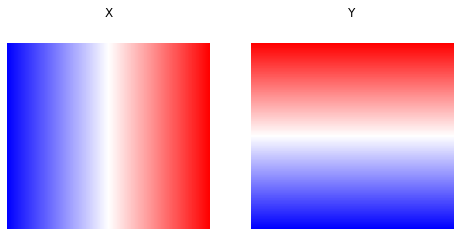

In [22]:
fig, axes = plt.subplots(1, 2)
for ax, data, title in zip(axes.ravel(), [x_mesh, y_mesh], ['X', 'Y']):
    ax.matshow(data, extent=extent, cmap='bwr'); ax.set_axis_off(); ax.set_title(title)

In [23]:
SGMA_Merged_gpd.loc[:, 'X_INDEX'] = ((SGMA_Merged_gpd.LONGITUDE - xmin) / pixel_size).astype(int)
SGMA_Merged_gpd.loc[:, 'Y_INDEX'] = (shape[0] - ((SGMA_Merged_gpd.LATITUDE - ymin) / pixel_size)).astype(int)

In [101]:
# Create a numpy array to fill with the net water level values according to pixels

SGMA_array = np.zeros(shape)
SGMA_array[:] = np.nan
SGMA_array[SGMA_Merged_gpd.Y_INDEX, SGMA_Merged_gpd.X_INDEX] = NET_WL 
SGMA_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

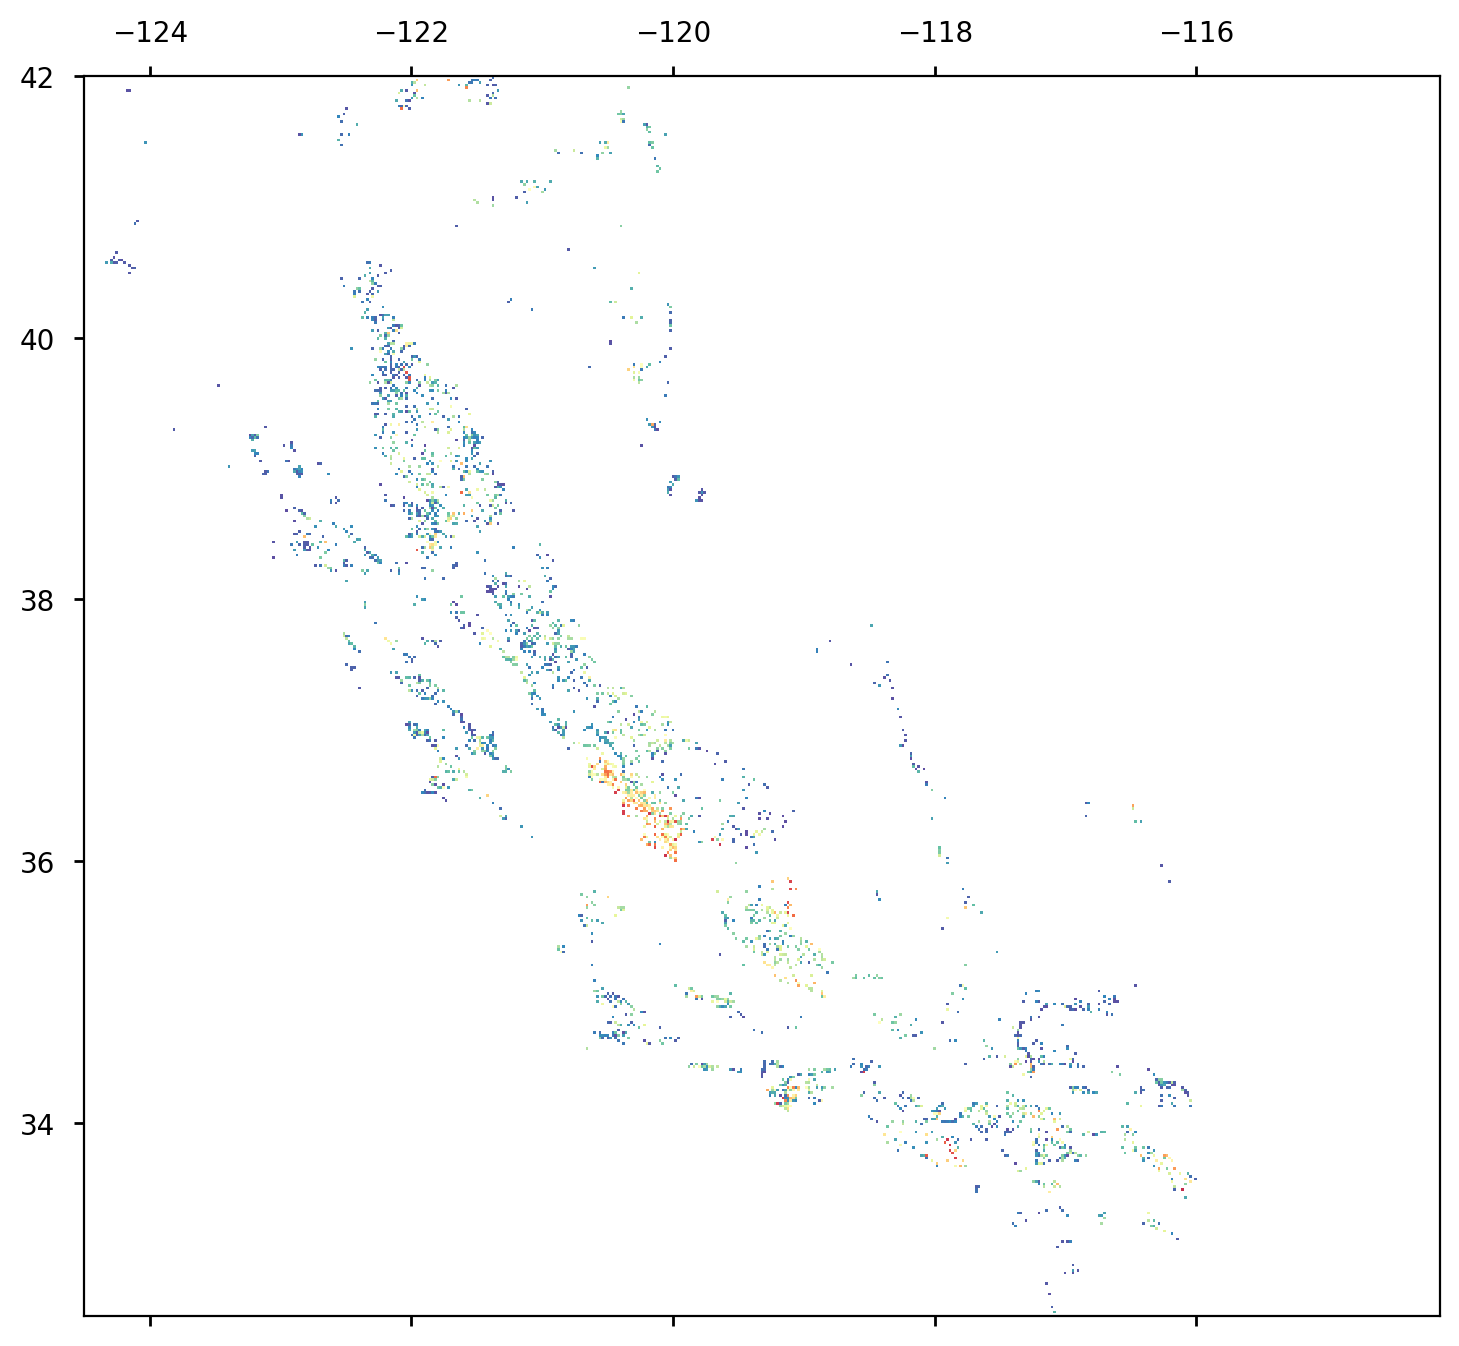

In [25]:
# Visualize the numpy array as pixels in a map

plt.matshow(SGMA_array, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
plt.gcf().set_size_inches(12, 8)
plt.gcf().set_dpi(200)

## Predict Interpolated Raster Pixels with Machine Learning

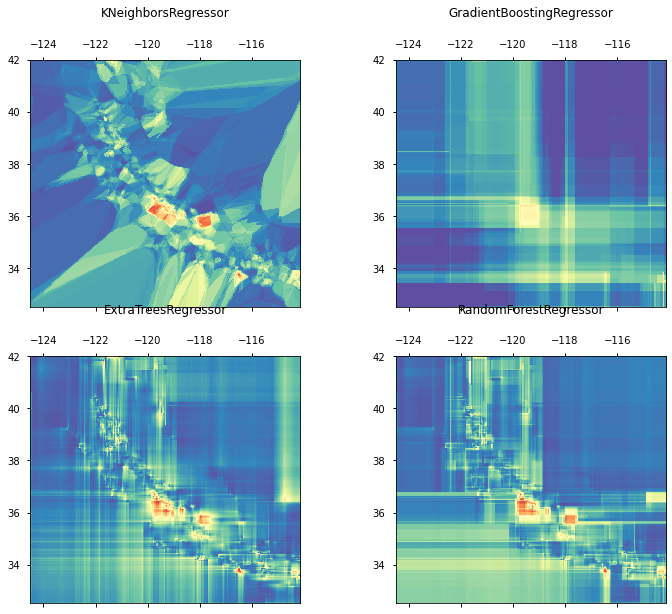

In [90]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

regrs = [KNeighborsRegressor(),
        GradientBoostingRegressor(),
        ExtraTreesRegressor(),
        RandomForestRegressor()
       ]

preds_2d = dict()

y_fit = SGMA_array[np.isfinite(SGMA_array)]
x_index_fit, y_index_fit = np.where(np.isfinite(SGMA_array))
x_index_pred, y_index_pred = np.where(SGMA_array)

X_fit = MinMaxScaler().fit_transform(np.vstack([x_index_fit, y_index_fit]).T)
X_pred = MinMaxScaler().fit_transform(np.vstack([x_index_pred, y_index_pred]).T)

fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, regr, title in zip(axes.ravel(),
                          regrs,
                          ['KNeighborsRegressor', 
                           'GradientBoostingRegressor', 
                           'ExtraTreesRegressor', 
                           'RandomForestRegressor']):

    regr.fit(X=X_fit, y=y_fit)
    y_pred = regr.predict(X=X_pred)
    preds_2d[title] = y_pred
    ax.matshow(y_pred.reshape(shape), extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, y=1.15)

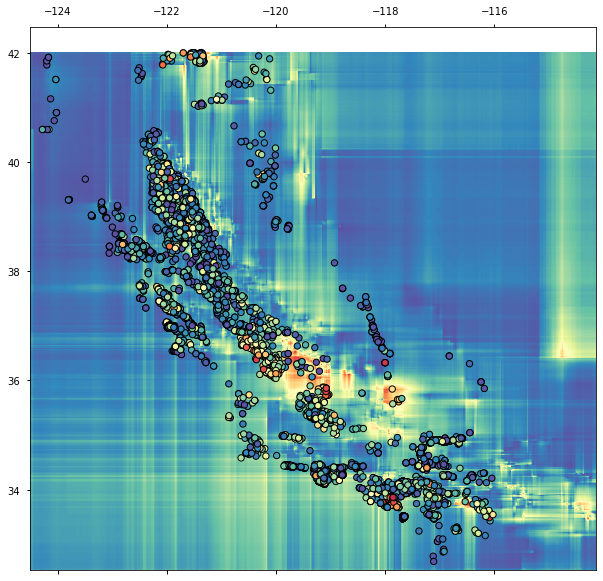

In [91]:
NET_WL_RF_2d = preds_2d['RandomForestRegressor'].reshape(shape)
NET_WL_ETF_2d = preds_2d['ExtraTreesRegressor'].reshape(shape)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.matshow(NET_WL_ETF_2d, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
ax.scatter(SGMA_Merged_gpd.LONGITUDE[::25], SGMA_Merged_gpd.LATITUDE[::25], 
           cmap=cmap, s=40, c=NET_WL[::25], vmin=vmin, vmax=vmax, linewidths=1, edgecolors='k')

In [116]:
# Compare interpolated arrays with original numpy pixel array on mean squared error and r-squared
RF_2d_MSE = np.mean((SGMA_array[np.isfinite(SGMA_array)] - NET_WL_RF_2d[np.isfinite(SGMA_array)])**2)
ETF_2d_MSE = np.mean((SGMA_array[np.isfinite(SGMA_array)] - NET_WL_ETF_2d[np.isfinite(SGMA_array)])**2)

RF_2d_R = np.corrcoef(SGMA_array[np.isfinite(SGMA_array)], NET_WL_RF_2d[np.isfinite(SGMA_array)])
ETF_2d_R = np.corrcoef(SGMA_array[np.isfinite(SGMA_array)], NET_WL_ETF_2d[np.isfinite(SGMA_array)])

RF_2d_R2 = RF_2d_R[0,1]**2
ETF_2d_R2 = ETF_2d_R[0,1]**2

print("RF MSE:",RF_2d_MSE)
print("ETF MSE:",ETF_2d_MSE)
print("RF R-Squared:",RF_2d_R2)
print("ETF R-Squared:",ETF_2d_R2)

RF MSE: 100773.03617243111
ETF MSE: 97278.01376401604
RF R-Squared: 0.02342753635293788
ETF R-Squared: 0.03702947068620269


In [27]:
n_angles = 60

X_var, Y_var, angle = np.meshgrid(x_range, y_range, n_angles)

angles = np.deg2rad(np.linspace(0, 180, n_angles, endpoint=False))

X = X_var + np.tan(angles) * Y_var

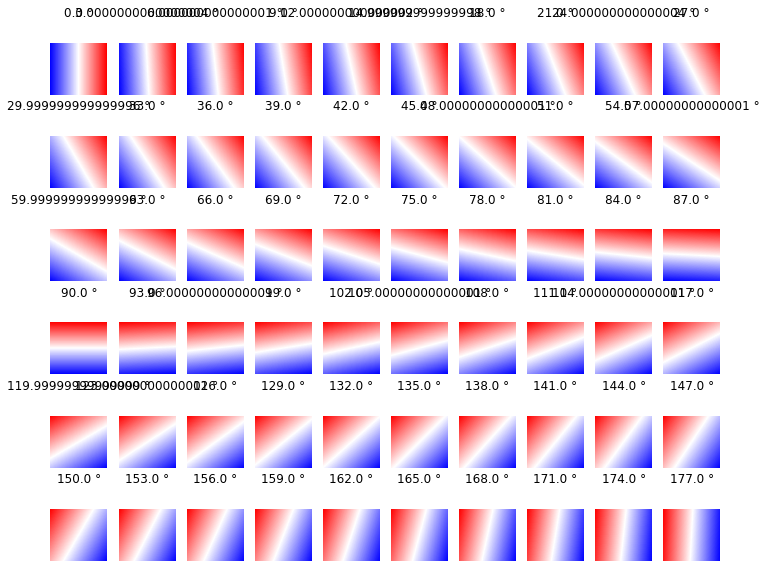

In [28]:
X[:,:,np.int((n_angles/2)+1):] = np.flipud(np.fliplr(X[:,:,np.int((n_angles/2)+1):]))

fig, axes = plt.subplots(6, 10, figsize=(12, 10))
for ax, data, angle in zip(axes.ravel(), np.dsplit(X, 60), angles):
    ax.matshow(data.squeeze(), extent=extent, cmap='bwr'); ax.set_axis_off()
    ax.set_title(u'{} °'.format(str(np.rad2deg(angle))))

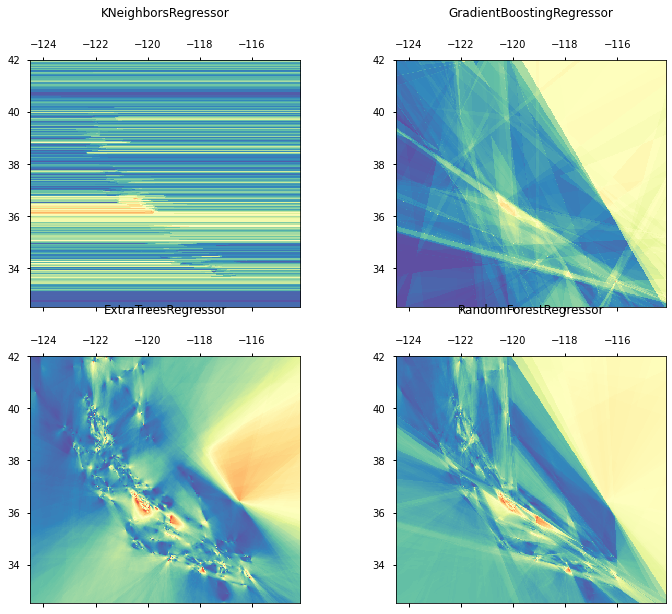

In [29]:
X_fit = X[x_index_fit, y_index_fit]

X_pred = X.reshape(-1, 60)
preds = dict()
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, regr, title in zip(axes.ravel(),
                          regrs,
                            ['KNeighborsRegressor',
                             'GradientBoostingRegressor', 
                             'ExtraTreesRegressor', 
                             'RandomForestRegressor']):

    regr.fit(X=X_fit, y=y_fit)
    y_pred = regr.predict(X=X_pred)
    preds[title] = y_pred
    ax.matshow(y_pred.reshape(shape), extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, y=1.15)

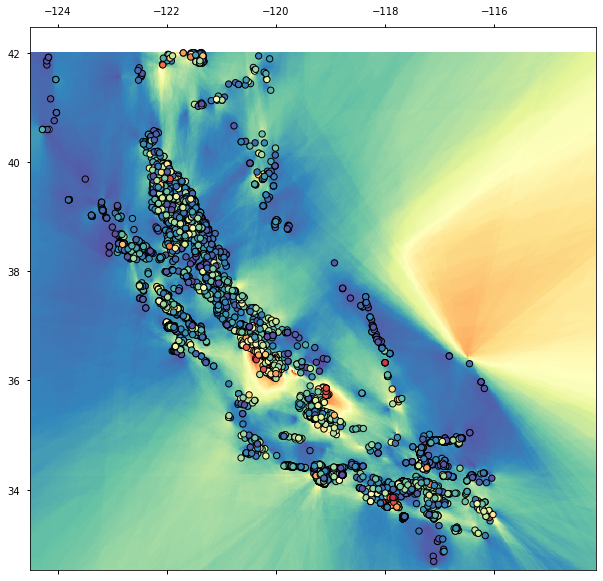

In [30]:
NET_WL_RF = preds['RandomForestRegressor'].reshape(shape)
NET_WL_ETF = preds['ExtraTreesRegressor'].reshape(shape)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.matshow(NET_WL_ETF, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
ax.scatter(SGMA_Merged_gpd.LONGITUDE[::25], SGMA_Merged_gpd.LATITUDE[::25], 
           cmap=cmap, s=40, c=NET_WL[::25], vmin=vmin, vmax=vmax, linewidths=1, edgecolors='k')

In [117]:
# Compare interpolated arrays with original numpy pixel array on mean squared error and r-squared
RF_MSE = np.mean((SGMA_array[np.isfinite(SGMA_array)] - NET_WL_RF[np.isfinite(SGMA_array)])**2)
ETF_MSE = np.mean((SGMA_array[np.isfinite(SGMA_array)] - NET_WL_ETF[np.isfinite(SGMA_array)])**2)

RF_R = np.corrcoef(SGMA_array[np.isfinite(SGMA_array)], NET_WL_RF[np.isfinite(SGMA_array)])
ETF_R = np.corrcoef(SGMA_array[np.isfinite(SGMA_array)], NET_WL_ETF[np.isfinite(SGMA_array)])

RF_R2 = RF_R[0,1]**2
ETF_R2 = ETF_R[0,1]**2

print("RF MSE:",RF_MSE)
print("ETF MSE:",ETF_MSE)
print("RF R-Squared:",RF_R2)
print("ETF R-Squared:",ETF_R2)

RF MSE: 6970.768113873417
ETF MSE: 3.2196324229079917e-25
RF R-Squared: 0.9367157628085989
ETF R-Squared: 1.0


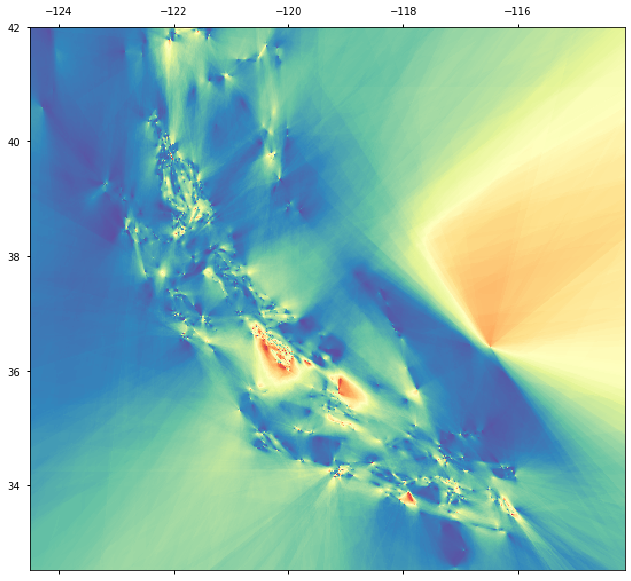

In [31]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.matshow(NET_WL_ETF, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
## Correct Projection

In [143]:
## Mis-projection seems to come through transformation

#from rasterio.transform import Affine
#x = SGMA_Merged_gpd.LONGITUDE
#y = SGMA_Merged_gpd.LATITUDE
#res = (x[x.shape[0]-1] - x[0]) / 240 # East-most point minus west-most point; X_Max - X_Min
#transform = Affine.translation(x[0] - res / 2, y[0] - res / 2) * Affine.scale(res, res)
#print(res)
#print(transform)

0.010791291666666621
| 0.01, 0.00,-121.98|
| 0.00, 0.01, 36.99|
| 0.00, 0.00, 1.00|


In [72]:
from rasterio.transform import Affine

res = (X_Max - X_Min) / NET_WL_ETF.shape[1] # East-most point minus west-most point; X_Max - X_Min
transform = Affine.translation(X_Min - res / 2, Y_Min - res / 2) * Affine.scale(res, res)
print(res)
transform

0.019943727140061544


Affine(0.019943727140061544, 0.0, -124.49198872435052,
       0.0, 0.019943727140061544, 32.51886487280248)

In [73]:
import rasterio
crs = rasterio.crs.CRS.from_epsg(4326)

In [75]:
new_dataset = rasterio.open(
'/tmp/new.tif',
'w',
driver='GTiff',
height=NET_WL_ETF.shape[0], #rows in the dataset
width=NET_WL_ETF.shape[1], #columns in the dataset
count=1,
dtype=NET_WL_ETF.dtype,
crs=crs,
transform=transform,
nodata=np.nan)

In [76]:
new_dataset.write(np.flipud(NET_WL_ETF),1)
new_dataset.close()

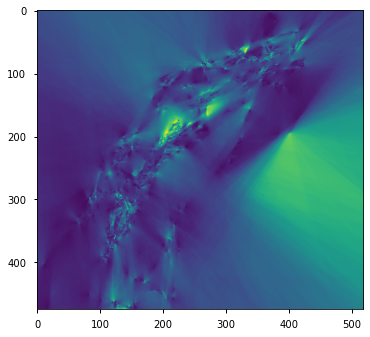

In [77]:
from matplotlib import pyplot
test_dataset = rasterio.open('/tmp/new.tif', 
                             driver='GTiff',
                             height=NET_WL_ETF.shape[0],
                             width=NET_WL_ETF.shape[1],
                             count=1,
                             dtype=NET_WL_ETF.dtype,
                             crs=crs)

pyplot.imshow(test_dataset.read(1),cmap='viridis')
pyplot.show()

### Mask out CA Boundary

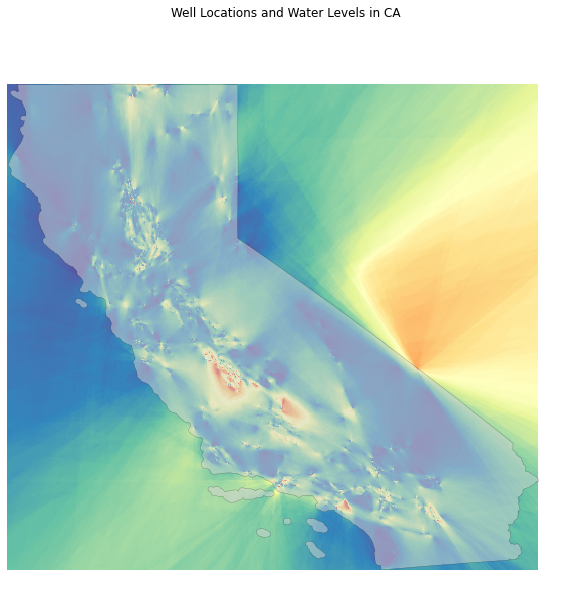

In [78]:
fig, ax = plt.subplots(figsize = (10, 10))

# first setup the plot using the crop_extent layer as the base layer 
shape_file.plot(color='lightgrey',
                      edgecolor = 'black',
                      ax = ax,
                      alpha=.5)
# then add another layer using geopandas syntax .plot, and calling the ax variable as the axis argument


#ax.scatter(SGMA_Merged_gpd.LONGITUDE, SGMA_Merged_gpd.LATITUDE, 
#           cmap=cmap, s=40, c=NET_WL, vmin=vmin, vmax=vmax, linewidths=1, edgecolors='k')


ax.matshow(NET_WL_ETF, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)

# add a title to the plot
ax.set_title('Well Locations and Water Levels in CA')
ax.set_axis_off()
plt.axis('equal')
plt.show()


In [79]:
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

with rasterio.open('/tmp/new.tif', crs = crs) as src:
    raster_crop, raster_crop_meta = es.crop_image(src, shape_file)

raster_crop_affine = raster_crop_meta["transform"]

# Create spatial plotting extent for the cropped layer
raster_extent = plotting_extent(raster_crop[0], raster_crop_affine)

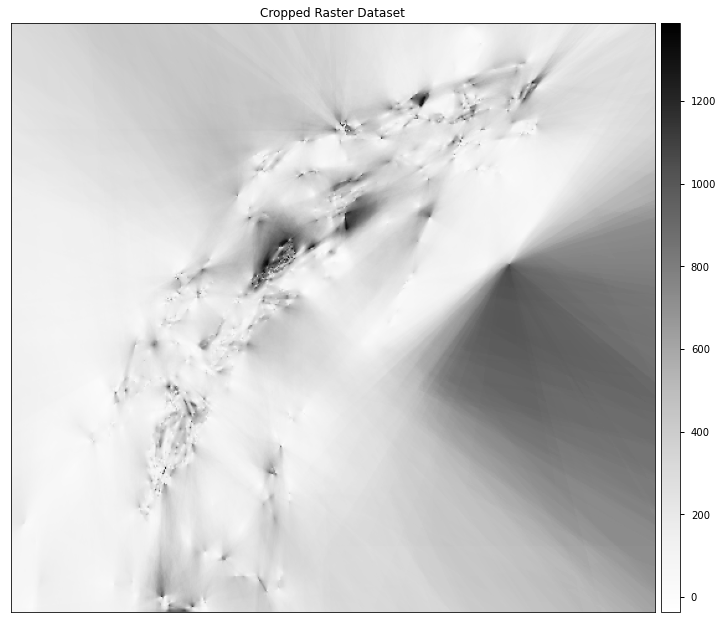

In [80]:
# Plot your data
ep.plot_bands(raster_crop[0],
              extent=raster_extent,
              cmap='Greys',
              title="Cropped Raster Dataset",
              scale=False)
plt.show()

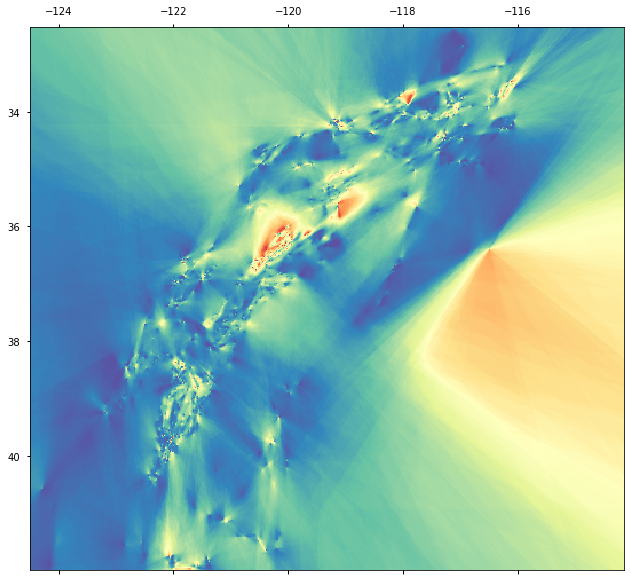

In [81]:
# Somehow flipped CA upside and mirrored right-left
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.matshow(raster_crop[0,:,:], extent=raster_extent, cmap=cmap, vmin=vmin, vmax=vmax)


In [82]:
with fiona.open('CA_bound_reproj.shp', "r") as shapefile:
    shapes = [feature['geometry'] for feature in shapefile]

In [83]:
src.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': nan,
 'width': 519,
 'height': 475,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.019943727140061544, 0.0, -124.49198872435052,
        0.0, 0.019943727140061544, 32.51886487280248)}

In [84]:
with rasterio.open('/tmp/new.tif', crs = crs) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta.copy()
    
out_meta.update({'driver':'GTiff',
                'height': out_image.shape[1],
                'width': out_image.shape[2],
                'transform': out_transform,
                'nodata': None})

with rasterio.open('wells_masked.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

In [85]:
out_transform

Affine(0.019943727140061544, 0.0, -124.49198872435052,
       0.0, 0.019943727140061544, 32.51886487280248)

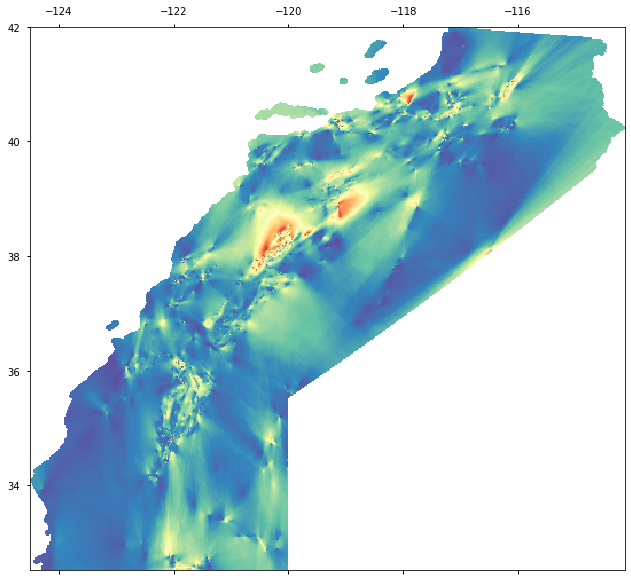

In [86]:
# Somehow flipped CA upside and mirrored right-left
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.matshow(out_image[0,:,:], extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)


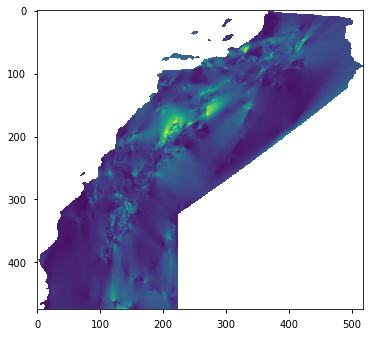

In [87]:
out_test_dataset = rasterio.open('wells_masked.tif', 
                             driver='GTiff',
                             height=out_image.shape[1],
                             width=out_image.shape[2],
                             count=1,
                             dtype=out_image.dtype)

pyplot.imshow(out_test_dataset.read(1),cmap='viridis')
pyplot.show()

In [88]:
out_test_dataset.crs

CRS.from_epsg(4326)

### Interpolation Accuracy Assessment

array([[ 37.176  ,  26.579  ,  25.156  , ..., 227.0482 , 227.0482 ,
        227.0482 ],
       [ 41.483  ,  27.9495 ,  21.651  , ..., 229.1042 , 229.1042 ,
        229.2352 ],
       [ 48.335  ,  32.1005 ,  24.284  , ..., 229.1042 , 229.2352 ,
        229.2352 ],
       ...,
       [271.59541, 272.02731, 271.94231, ..., 229.4514 , 222.4767 ,
        189.0919 ],
       [271.59541, 270.73941, 271.94231, ..., 228.7094 , 224.1832 ,
        206.8866 ],
       [273.68191, 274.88481, 274.88481, ..., 227.5874 , 229.8814 ,
        219.9091 ]])

## Add SGMA Data to GEE

In [59]:
ee.Initialize()

In [89]:
SGMA_Map = geemap.Map()
SGMA_Map.add_raster('wells_masked.tif', colormap='viridis', layer_name='SGMA_Interpolated')
# SGMA_Map.add_raster('/tmp/new.tif', colormap='viridis',layer_name='Temp Raster') #Unmasked data
SGMA_Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

## GEEMAP Visualizations

In [44]:
ca_bound = ee.FeatureCollection('users/theaaronscherf/ca-state-boundary')
CA_Map = geemap.Map()
CA_Map.addLayer(ca_bound)

In [45]:
farmview_data = ee.FeatureCollection('users/theaaronscherf/own_cropland')
CA_Map.addLayer(farmview_data)
CA_Map.centerObject(ca_bound, zoom=6)
CA_Map

Map(center=[37.15243771573542, -119.5265626992281], controls=(WidgetControl(options=['position'], widget=HBox(…

In [46]:
Acreage_Map = geemap.Map()
empty = ee.Image().float()
palette = ['FF0000', '00FF00', '0000FF']
viz = {'min':1, 'max':1000, 'palette':palette}


fills = empty.paint(featureCollection = farmview_data,color='crop_acres')
Acreage_Map.centerObject(farmview_data, 10)
Acreage_Map.addLayer(fills, viz,'crop acreage')
Acreage_Map

Map(center=[36.386816818707885, -121.23547940313944], controls=(WidgetControl(options=['position'], widget=HBo…

In [47]:
Map = geemap.Map()

NLCD2016 = ee.Image('USGS/NLCD/NLCD2016').select('landcover')
nlcd_vis = {
    'bands': ['landcover']
}

Map.addLayer(NLCD2016, nlcd_vis, 'landcover')

In [48]:
Private = farmview_data \
    .filter(ee.Filter.eq("public_pri", 'private')) 

Public = farmview_data \
    .filter(ee.Filter.eq("public_pri", 'public')) 

Map.centerObject(farmview_data, 10)
Map.addLayer(Private, {'opacity':0.5}, 'private')
Map.addLayer(Public, {'opacity':0.5}, 'public')
Map

Map(center=[36.386816818707885, -121.23547940313944], controls=(WidgetControl(options=['position'], widget=HBo…

In [49]:
#out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
#nlcd_stats = os.path.join(out_dir, 'nlcd_stats.csv')  

# statistics_type can be either 'SUM' or 'PERCENTAGE'
# denominator can be used to convert square meters to other areal units, such as square kilimeters
#geemap.zonal_statistics_by_group(NLCD2016, farmview_data, nlcd_stats, statistics_type='SUM', denominator=1000000, decimal_places=2)

In [50]:
#import ipywidgets as widgets
#from ipyleaflet import WidgetControl

#dropdown = widgets.Dropdown(
#    options=[('landcover', 1), ('private', 2), ('public', 3), ('Public and Private', 4), ('Show all layers', 5)],
#    value=5,
#    description='Select layer',
#)

#dropdown_control = WidgetControl(widget=dropdown, position='topright')

#all_layers = Map.layers

#def on_change(change):
#    if change['type'] == 'change' and change['name'] == 'value':
#        if change['new'] == 5: 
#            Map.layers = all_layers
#        else:
#            Map.layers = Map.layers[:3] 
#            layer_index = change['new'] + 2
#            Map.add_layer(all_layers[layer_index])

            
#dropdown.observe(on_change)
#Map.add_control(dropdown_control)
#Map

In [51]:
collection = ee.ImageCollection('GRIDMET/DROUGHT')

#Filter by date
dS = '2017-01-30'
dE = '2017-01-30'
dSUTC = ee.Date(dS, 'GMT')
dEUTC = ee.Date(dE, 'GMT')
filtered = collection.filterDate(dSUTC, dEUTC.advance(365, 'day'))

# Select variables pdsi and z
PDSI = filtered.select('pdsi')

# Make a color palette that is similar to USDM drought classification
usdmColors = "0000aa,0000ff,00aaff,00ffff,aaff55,ffffff,ffff00,fcd37f,ffaa00,e60000,730000";

# Make color options for Palmer variables psdi/z
minColorbar= -6
maxColorbar= 6
colorbarOptions2 = {
  'min':minColorbar,
  'max':maxColorbar,
  'palette': usdmColors
}

# Add map layers to Google Map
pdsi_Map = geemap.Map()
pdsi_Map.addLayer(ee.Image(PDSI.mean()), colorbarOptions2, 'PDSI');
pdsi_Map.centerObject(ca_bound, zoom=6)
pdsi_Map

Map(center=[37.15243771573542, -119.5265626992281], controls=(WidgetControl(options=['position'], widget=HBox(…

In [12]:
naip_ts = geemap.naip_timeseries(start_year=2009, end_year=2018, roi=ca_bound)

In [13]:
layer_names = ['NAIP ' + str(year) for year in range(2009, 2019)]
naip_vis = {'bands': ['N', 'R', 'G']}

Create a split-panel map for visualizing NAIP imagery. Use the dropdown menus in the top corners to select the layer years.

In [14]:
naip_Map = geemap.Map()
naip_Map.ts_inspector(left_ts=naip_ts, right_ts=naip_ts, left_names=layer_names, right_names=layer_names, left_vis=naip_vis, right_vis=naip_vis)
naip_Map.centerObject(ca_bound, zoom=6)
naip_Map

Map(center=[37.15243771573526, -119.5265626992281], controls=(WidgetControl(options=['position'], widget=Dropd…